In [137]:
import numpy as np
import random
import copy
import scipy
from scipy import stats
import sys
import time
import matplotlib.pyplot as plt
import pdb
from sklearn.preprocessing import MinMaxScaler

In [138]:
class GridWorldWithPits():
    def __init__(self, P, R, H = 10, init_state = 0, randomized = False):
        self.R = R
        self.P = P
        self.H = H
        self.randomized = randomized
        self.init_state = init_state
        self.state_memory = []
        self.reset()
 
    def reward_func(self, state, action):
        return self.R[state, action]
 
    def reset(self):
        self.state = self.init_state
        if self.randomized == True:
            self.state = np.random.randint(0,np.shape(self.P)[0])
        self.state_memory.append(self.state)
        self.t = 0

    def _step(self, action):
        reward = self.R[self.state, action]
        self.state = self.P[self.state, action]
        self.t +=1
        return reward, self.state, (self.t == self.H)
 
    def step(self, policy):
        action = np.random.choice(np.arange(5), p = policy.eval(self.state)).item()
        reward = self.R[self.state, action]
        self.state = self.P[self.state, action]
        self.t +=1
        if self.t == self.H: 
            done = True
        else: done = False
        return reward, done

#define deterministic transitions
P = np.array([[4,1,0,0,0],
     [5,2,1,0,1],
     [6,3,2,1,2],
     [7,3,3,2,3],
     [8,5,0,4,4],
     [9,6,1,4,5],
     [10,7,2,5,6],
     [11,7,3,6,7],
     [8,9,4,8,8],
     [9,10,5,8,9],
     [10,11,6,9,10],
     [11,11,7,10,11]])

#define rewards
R = -0.1*np.ones((12,5))
R[7,0] = 0.5
R[10,1] = 0.5
R[11,4] = 0.5
R[1,0] = -1
R[4,1] = -1
R[9,2] = -1
R[6,3] = -1
R[5,4] = -1

R = MinMaxScaler().fit_transform(R.flatten().reshape(-1,1)).reshape(R.shape)


baseline_policy = np.array([[0,1,0,0,0],
                            [0,1,0,0,0],
                            [0.5,0.5,0,0,0],
                            [1,0,0,0,0],
                            [0,0,1,0,0],
                            [0,1,0,0,0],
                            [1,0,0,0,0],
                            [0.5,0,0,0.5,0],
                            [0,0,1,0,0],
                            [0,0,0,1,0],
                            [0,0.5,0,0.5,0],
                            [0,0,0,0,1]])

In [160]:
class CUCBVI(object):
    def __init__(self,env,baseline_policy,K,bonus_coef,delta):
        self.env = env
        self.baseline_policy = baseline_policy
        self.K = K
        self.bonus_coef = bonus_coef
        self.delta = delta

        self.buffer = [[] for _ in range(self.K)]
        self.N_sas = np.zeros((np.shape(self.env.P)[0], np.shape(self.env.P)[1], np.shape(self.env.P)[0]))
        self.N_sa = np.zeros((np.shape(self.env.P)[0], np.shape(self.env.P)[1]))

        self.R = np.zeros((np.shape(self.env.P)[0], np.shape(self.env.P)[1]))
        self.P = np.zeros((np.shape(self.env.P)[0], np.shape(self.env.P)[1], np.shape(self.env.P)[0]))
        self.Q = np.zeros((self.env.H, np.shape(self.env.P)[0], np.shape(self.env.P)[1]))
        
        
    def update_buffer(self,s,a,r,s_,k):
        self.buffer[k].append((s,a,r,s_))
    
    def act(self,s,h):
        #return np.argmax(self.Q[h,s,:])
        return np.random.choice(np.flatnonzero(self.Q[h,s,:] == self.Q[h,s,:].max()))

    def act_baseline(self,s):
        return np.random.choice(range(self.baseline_policy.shape[1]), p=self.baseline_policy[s])
    
    def learn(self,k):
        self.update_counts_and_rewards(k)
        self.update_probability_transition()
        self.update_value_functions()

    def update_counts_and_rewards(self, k):
        for step in self.buffer[k]:
            s,a,r,s_ = step
            self.R[s,a] = self.R[s,a]*self.N_sa[s,a] + r
            self.N_sas[s,a,s_] += 1
            self.N_sa[s,a] += 1
            self.R[s,a] /= self.N_sa[s,a]
    
    def update_probability_transition(self):
        for s in range(self.env.P.shape[0]):
            for a in range(self.env.P.shape[1]):
                if self.N_sa[s,a] > 0:
                    for s_ in range(self.env.P.shape[0]):
                        self.P[s,a,s_] = self.N_sas[s,a,s_] / self.N_sa[s,a]
    
    def update_value_functions(self):
        V = np.zeros((self.env.H + 1, self.env.P.shape[0]))
        for h in range(self.env.H - 1, -1, -1):
            for s in range(self.env.P.shape[0]):
                for a in range(self.env.P.shape[1]):
                    if self.N_sa[s,a] > 0:
                        self.Q[h,s,a] = min(self.env.H - h, self.R[s,a] + self.bonus(s,a) + np.dot(self.P[s,a,:], V[h+1,:]))
                        #self.Q[h,s,a] = min(min(self.Q[h,s,a], self.env.H), self.R[s,a] + self.bonus(s,a) + np.dot(self.P[s,a,:], V[h+1,:]))
                    else:
                        self.Q[h,s,a] = self.env.H - h
                        #self.Q[h,s,a] = self.env.H
                V[h,s] = min(self.env.H - h, np.max(self.Q[h,s,:]))
                #V[h,s] = np.max(self.Q[h,s,:])

    def compute_pessismistic_estimate(self):
        V = np.zeros((self.env.H + 1, self.env.P.shape[0]))
        for h in range(self.env.H - 1, -1, -1):
            for s in range(self.env.P.shape[0]):
                pol = np.array(self.Q[h,s,:] == self.Q[h,s,:].max(), dtype=int)/np.sum(self.Q[h,s,:] == self.Q[h,s,:].max())
                for a in range(self.env.P.shape[1]):
                    if self.N_sa[s,a] > 0:
                        V[h,s] += pol[a]*(self.R[s,a] - self.bonus(s,a) + np.dot(self.P[s,a,:], V[h+1,:]))
                V[h,s] = max(0, V[h,s])
        return V[0,:]
                   
    def bonus(self,s,a):
        return self.bonus_coef*(self.env.H + 1)*np.sqrt(np.log(self.N_sa[s,a]/self.delta)/self.N_sa[s,a])
        #return self.bonus_coef*(7*self.env.H/np.sqrt(self.N_sa[s,a]))*np.log(5*self.env.P.shape[0]*self.env.P.shape[1]*self.env.H*self.K/self.delta)

    def evaluate_payoff(self, baseline=False):
        cum_reward = 0
        self.env.reset()
        done = False
        while not done:
            s = self.env.state
            h = self.env.t
            if baseline:
                a = self.act_baseline(s)
            else:
                a = self.act(s,h)
            r, s_, done = self.env._step(a)
            cum_reward += r
        return cum_reward

In [209]:
#random seed for reproducible results
#without_conservative: set to True to run UCB-VI, or False to run CUCB-VI

np.random.seed(0)
without_conservative = False
all_regrets = []
all_budgets = []

for _ in range(30):

    env = GridWorldWithPits(P, R)
    K = 300 #number of episodes
    alpha = 0.05 #conservative alpha parameter
    agent = CUCBVI(env, baseline_policy, K, bonus_coef=0.01, delta=0.1) #bonus coef is the coefficient in front of the count-based bonus term, delta is the confidence parameter

    value_opt_pol = 8.4  #value of the optimal policy starting at initial state 0
    value_baseline_pol = 7.4 #value of the baseline policy starting at initial state 0 (computed by monte-carlo estimates)
    regrets = []
    budgets = [0]
    exec_baseline = False

    for k in range(K):
        env.reset()
        start_state = env.state
        v = agent.compute_pessismistic_estimate()[start_state]
        if without_conservative:
            exec_baseline = False
            budgets.append(budgets[-1] + v - (1-alpha)*value_baseline_pol)
        else:
            if budgets[-1] + v - (1-alpha)*value_baseline_pol >= 0:
                exec_baseline = False
                budgets.append(budgets[-1] + v - (1-alpha)*value_baseline_pol)
            else:
                exec_baseline = True
                budgets.append(budgets[-1] + alpha*value_baseline_pol)
        done = False
        while not done:
            s = env.state
            h = env.t
            if exec_baseline:
                a = agent.act_baseline(s)
            else:
                a = agent.act(s,h)
            r, s_, done = env._step(a)
            agent.update_buffer(s,a,r,s_,k)
        if exec_baseline:
            regrets.append(value_opt_pol - value_baseline_pol)
        else:
            regrets.append(value_opt_pol - agent.evaluate_payoff())
        agent.learn(k)

    all_regrets.append(np.cumsum(regrets))
    all_budgets.append(budgets)

all_regrets = np.array(all_regrets)
all_budgets = np.array(all_budgets)

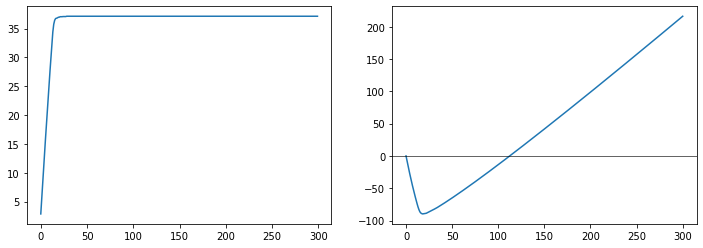

In [202]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.mean(all_regrets, axis=0))
axs[1].plot(np.mean(all_budgets, axis=0))
axs[1].axhline(color="k",linewidth=0.6)

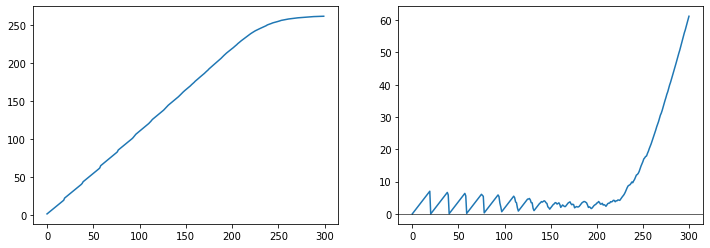

In [210]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.mean(all_regrets, axis=0))
axs[1].plot(np.mean(all_budgets, axis=0))
axs[1].axhline(color="k",linewidth=0.6)